# monocle and slingshot pseudotime estimations for healthy/IPF datasets

In [1]:
import numpy as np
import seaborn as sns
import anndata
import os
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
#import dandelion as ddl
#ddl.logging.print_header() #sc.logging.print_header()
anndata.__version__

'0.9.1'

In [2]:
%load_ext rpy2.ipython # pip install rpy2

In [4]:
dir_path = '../GOOGLE_DRIVE_MOUNT/G2G_Analysis/G2G_paper_related/'
adata_healthy = anndata.read_h5ad(dir_path + 'adata_healthy_AT2_to_AT1.h5ad')
adata_disease = anndata.read_h5ad(dir_path + 'adata_IPF_AT2_to_AberrantB.h5ad')

print(adata_healthy.X.data)
print(adata_disease.X.data)

adata_healthy_original = adata_healthy.copy()
adata_disease_original = adata_disease.copy()

# from literature
AT2_progenitor_markers = ['AXIN2','FGFR2', 'ID2', 'FZD6','LRP5','LRP6'] 

[1. 1. 4. ... 1. 1. 1.]
[1. 2. 1. ... 1. 1. 1.]


# monocle3

[1. 1. 4. ... 1. 1. 1.]


/home/jovyan/my-conda-envs/capital/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:152: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/tmp/ipykernel_1441/2350265680.py:11: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['iroot'] = rootcell
/tmp/ipykernel_1441/2350265680.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['rootcell'][rootcell] = 1


2215


/home/jovyan/my-conda-envs/capital/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


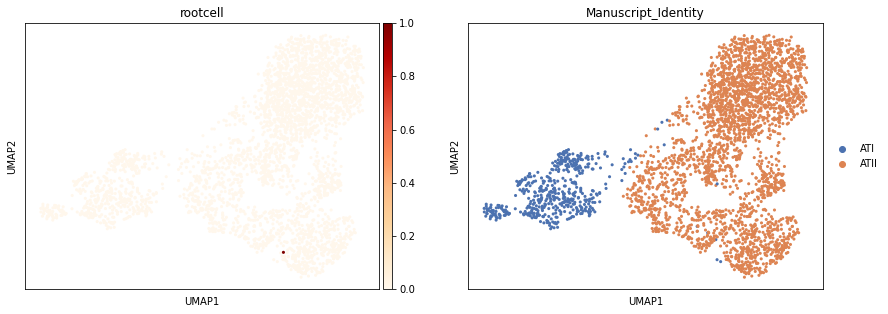

In [5]:
adata = adata_healthy_original.copy() 

print(adata.X.data)
sc.pp.normalize_per_cell(adata, 10000) 
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=4000)
sc.tl.score_genes(adata, gene_list=AT2_progenitor_markers, score_name='start_score')
adata = adata[:, adata.var.highly_variable]    
rootcell = np.argmax(adata.obs.start_score)
print(rootcell)
adata.uns['iroot'] = rootcell
adata.obs['rootcell'] = 0
adata.obs['rootcell'][rootcell] = 1
sc.pl.umap(adata,color=['rootcell','Manuscript_Identity'],color_map='OrRd')
#data prep for monocle3. need to subset the obs as rpy2 doesn't handle categoricals well now apparently
obs = adata.obs[['Manuscript_Identity']]
pca = adata.obsm['X_umap']
iroot = adata.obs_names[adata.obs['rootcell']==1]
expression = adata.X.todense() 
expression = np.matrix(expression) .transpose() 
pca = adata.obsm['X_umap']

[1] ‘0.2.3.0’
[1] 4000 3157
  |======================================================================| 100%


Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'br

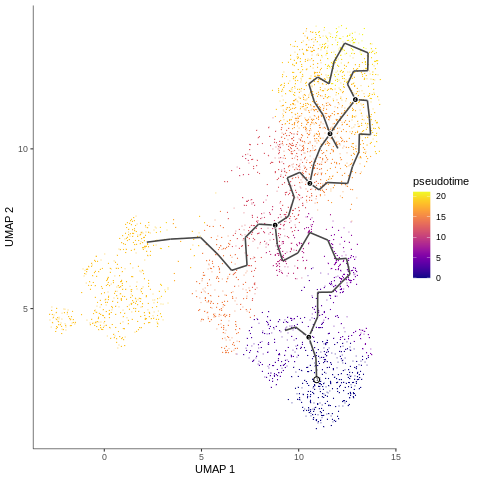

In [7]:
%%R -i obs -i expression -i pca -i iroot -o pseudotime 
        
library(monocle3)
print(packageVersion("monocle3"))

#create basic monocle object
#X = matrix(0,nrow=4000,ncol=dim(obs)[1])
mono = new_cell_data_set(expression, cell_metadata=obs)
print(dim(mono))

#hack in the UMAP into the appropriate object slot
umap = as.matrix(pca)
rownames(umap) = rownames(obs)
reducedDims(mono) = SimpleList(UMAP=umap)

#identify pseudotime graph structure, compute pseudotime
mono = cluster_cells(mono, reduction_method='UMAP')
mono = learn_graph(mono)
mono = order_cells(mono, root_cells=iroot)
pseudotime = mono@principal_graph_aux[['UMAP']]$pseudotime

#plot the various branchings R-side as this doesn't lend itself nicely to python porting
plot_cells(mono,
           color_cells_by = "pseudotime",
           label_cell_groups=FALSE,
           label_leaves=FALSE,
           label_branch_points=TRUE,
           graph_label_size=1.5)

/home/jovyan/my-conda-envs/capital/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


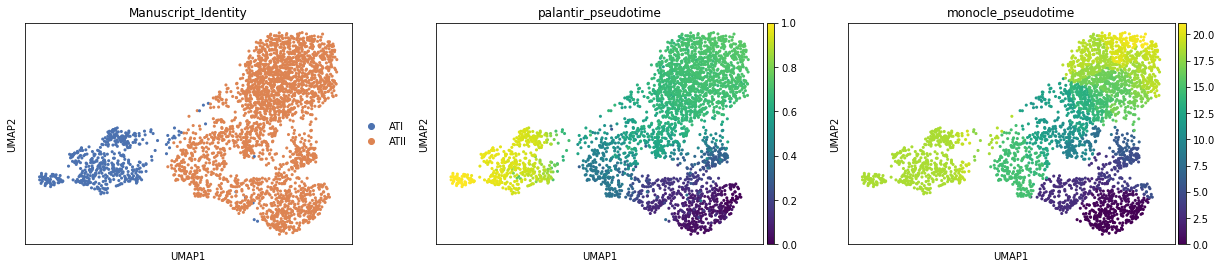

In [11]:
adata.obs['monocle_pseudotime'] = pseudotime
adata_healthy_original.obs['monocle_pseudotime'] = adata.obs['monocle_pseudotime']
sc.pl.umap(adata_healthy_original, color=['Manuscript_Identity','palantir_pseudotime', 'monocle_pseudotime' ])

/home/jovyan/my-conda-envs/capital/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:152: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/tmp/ipykernel_1441/714637826.py:10: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['iroot'] = rootcell
/tmp/ipykernel_1441/714637826.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['rootcell'][rootcell] = 1
/home/jovyan/my-conda-envs/capital/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


492


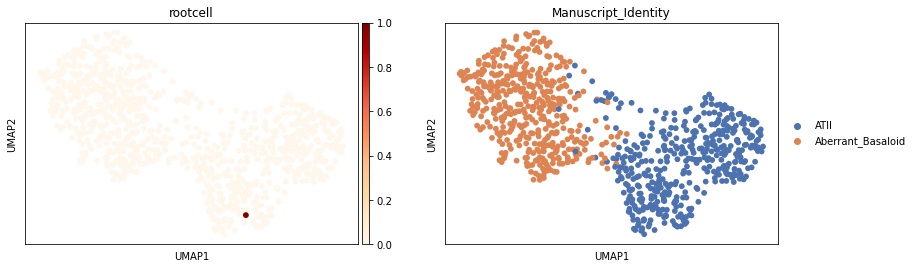

In [12]:
adata = adata_disease_original.copy() 

sc.pp.normalize_per_cell(adata, 10000) 
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=4000)
sc.tl.score_genes(adata, gene_list=AT2_progenitor_markers, score_name='start_score')
adata = adata[:, adata.var.highly_variable]    
rootcell = np.argmax(adata.obs.start_score)
print(rootcell)
adata.uns['iroot'] = rootcell
adata.obs['rootcell'] = 0
adata.obs['rootcell'][rootcell] = 1
sc.pl.umap(adata,color=['rootcell','Manuscript_Identity'],color_map='OrRd')
#data prep for monocle3. need to subset the obs as rpy2 doesn't handle categoricals well now apparently
obs = adata.obs[['Manuscript_Identity']]
pca = adata.obsm['X_umap']
iroot = adata.obs_names[adata.obs['rootcell']==1]
expression = adata.X.todense() 
expression = np.matrix(expression) .transpose() 
pca = adata.obsm['X_umap']

[1] ‘0.2.3.0’
[1] 4000  890
  |======================================================================| 100%


In addition: Warning message:
In new_cell_data_set(expression, cell_metadata = obs) :


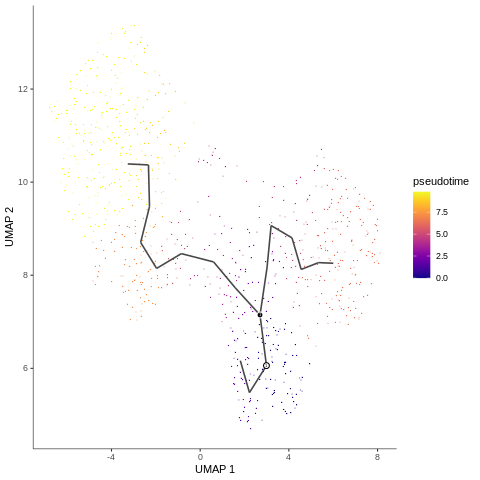

In [13]:
%%R -i obs -i expression -i pca -i iroot -o pseudotime 
        
library(monocle3)
print(packageVersion("monocle3"))

#create basic monocle object
#X = matrix(0,nrow=4000,ncol=dim(obs)[1])
mono = new_cell_data_set(expression, cell_metadata=obs)
print(dim(mono))

#hack in the UMAP into the appropriate object slot
umap = as.matrix(pca)
rownames(umap) = rownames(obs)
reducedDims(mono) = SimpleList(UMAP=umap)

#identify pseudotime graph structure, compute pseudotime
mono = cluster_cells(mono, reduction_method='UMAP')
mono = learn_graph(mono)
mono = order_cells(mono, root_cells=iroot)
pseudotime = mono@principal_graph_aux[['UMAP']]$pseudotime

#plot the various branchings R-side as this doesn't lend itself nicely to python porting
plot_cells(mono,
           color_cells_by = "pseudotime",
           label_cell_groups=FALSE,
           label_leaves=FALSE,
           label_branch_points=TRUE,
           graph_label_size=1.5)

/home/jovyan/my-conda-envs/capital/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


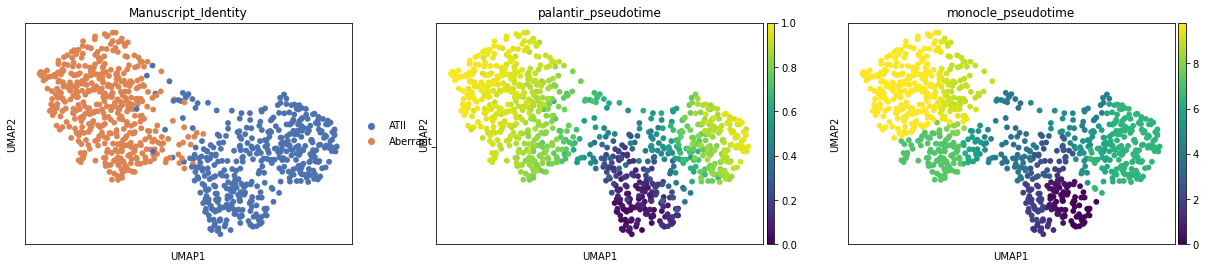

In [14]:
adata.obs['monocle_pseudotime'] = pseudotime
adata_disease_original.obs['monocle_pseudotime'] = adata.obs['monocle_pseudotime']
sc.pl.umap(adata_disease_original, color=['Manuscript_Identity','palantir_pseudotime', 'monocle_pseudotime' ])

# Slingshot 

In [16]:
#pip install pyslingshot

array([1., 1., 4., ..., 1., 1., 1.], dtype=float32)

/home/jovyan/my-conda-envs/capital/lib/python3.8/site-packages/pyslingshot/slingshot.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Lineages: [Lineage[1, 0]]


  0%|          | 0/1 [00:00<?, ?it/s]/home/jovyan/my-conda-envs/capital/lib/python3.8/site-packages/pyslingshot/slingshot.py:339: RuntimeWarning: invalid value encountered in divide
  cell_weights = z_prime / np.nanmax(z_prime, axis=1, keepdims=True) #rowMins(D) / D
100%|██████████| 1/1 [00:02<00:00,  2.84s/it]

Reversing from leaf to root
num cluster =  2


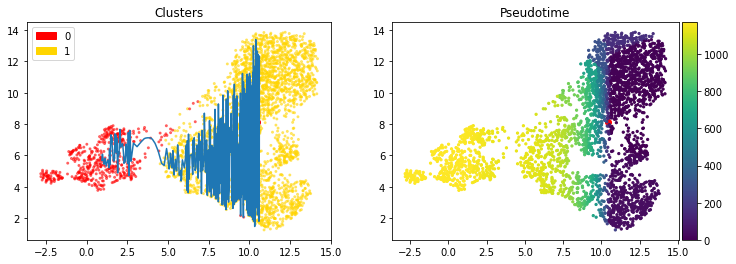

In [17]:
from pyslingshot import Slingshot 

adata = adata_healthy_original.copy() 
# start node = starting node of the minimum spanning tree
slingshot = Slingshot(adata, celltype_key="Manuscript_Identity", obsm_key="X_umap", start_node=1, debug_level='verbose')
slingshot.fit(num_epochs=1)
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
axes[0].set_title('Clusters')
axes[1].set_title('Pseudotime')
slingshot.plotter.curves(axes[0], slingshot.curves)
slingshot.plotter.clusters(axes[0], labels=np.arange(slingshot.num_clusters), s=4, alpha=0.5)
slingshot.plotter.clusters(axes[1], color_mode='pseudotime', s=5)
print('num cluster = ',slingshot.num_clusters)

adata.obs['slingshot_pseudotime'] = slingshot.unified_pseudotime

/home/jovyan/my-conda-envs/capital/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


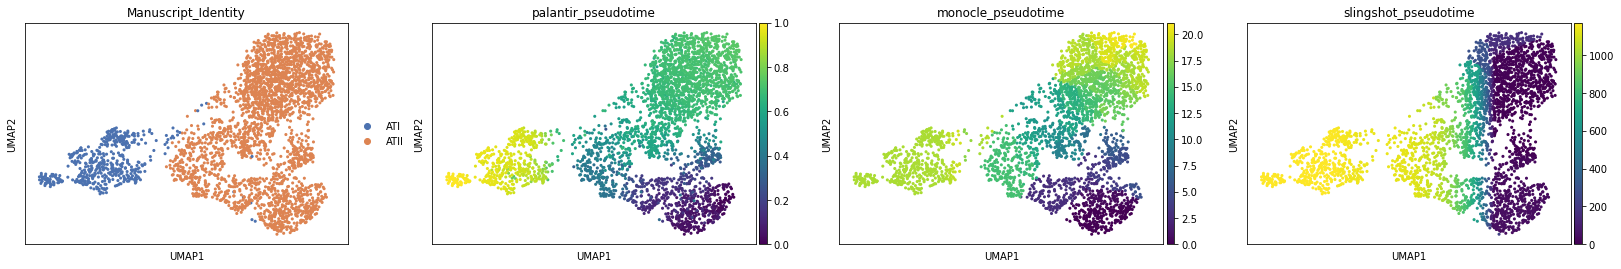

In [18]:
adata_healthy_original.obs['slingshot_pseudotime'] = adata.obs['slingshot_pseudotime']
sc.pl.umap(adata_healthy_original, color=['Manuscript_Identity','palantir_pseudotime', 'monocle_pseudotime' ,'slingshot_pseudotime'])

Lineages: [Lineage[0, 1]]


  0%|          | 0/1 [00:00<?, ?it/s]/home/jovyan/my-conda-envs/capital/lib/python3.8/site-packages/pyslingshot/slingshot.py:339: RuntimeWarning: invalid value encountered in divide
  cell_weights = z_prime / np.nanmax(z_prime, axis=1, keepdims=True) #rowMins(D) / D
100%|██████████| 1/1 [00:00<00:00,  2.27it/s]

Reversing from leaf to root
num cluster =  2



/home/jovyan/my-conda-envs/capital/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


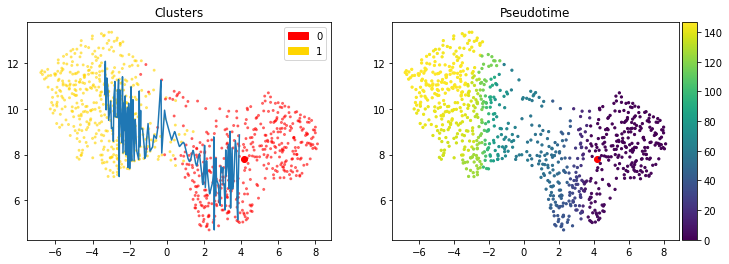

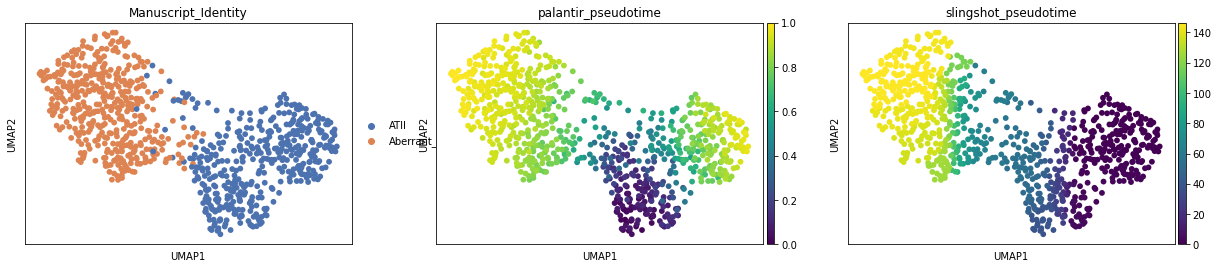

In [19]:
adata = adata_disease_original.copy() 
# start node = starting node of the minimum spanning tree
slingshot = Slingshot(adata, celltype_key="Manuscript_Identity", obsm_key="X_umap", start_node=0, debug_level='verbose')
slingshot.fit(num_epochs=1)
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
axes[0].set_title('Clusters')
axes[1].set_title('Pseudotime')
slingshot.plotter.curves(axes[0], slingshot.curves)
slingshot.plotter.clusters(axes[0], labels=np.arange(slingshot.num_clusters), s=4, alpha=0.5)
slingshot.plotter.clusters(axes[1], color_mode='pseudotime', s=5)
print('num cluster = ',slingshot.num_clusters)

adata.obs['slingshot_pseudotime'] = slingshot.unified_pseudotime
sc.pl.umap(adata, color=['Manuscript_Identity','palantir_pseudotime' ,'slingshot_pseudotime'])

/home/jovyan/my-conda-envs/capital/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


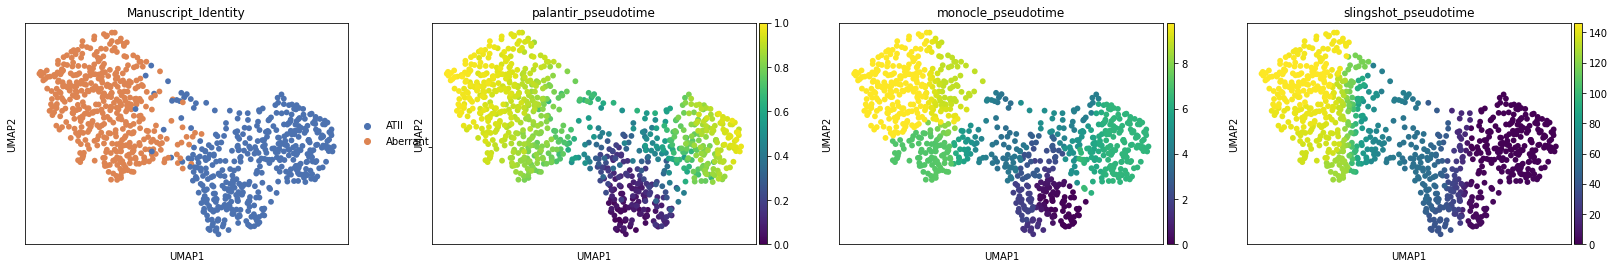

In [20]:
adata_disease_original.obs['slingshot_pseudotime'] = adata.obs['slingshot_pseudotime']
sc.pl.umap(adata_disease_original, color=['Manuscript_Identity','palantir_pseudotime', 'monocle_pseudotime' ,'slingshot_pseudotime'])

In [ ]:
# https://github.com/mossjacob/pyslingshot/blob/master/slingshot.ipynb

/home/jovyan/my-conda-envs/capital/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


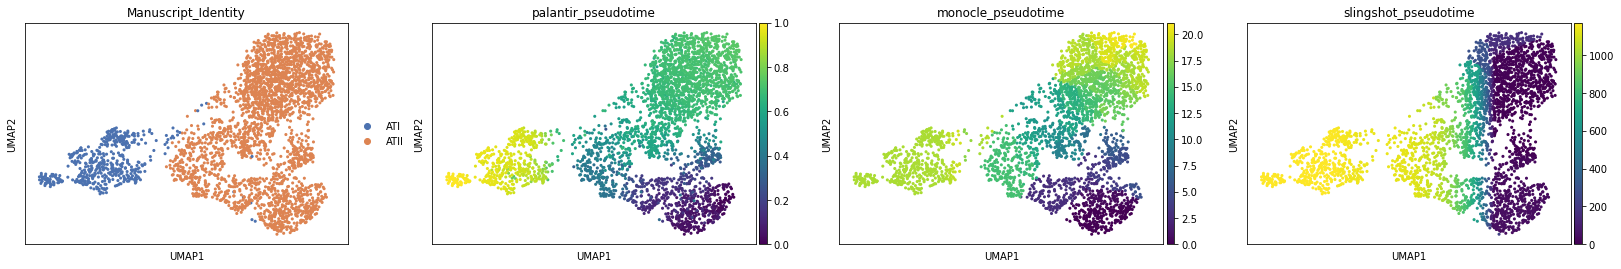

/home/jovyan/my-conda-envs/capital/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


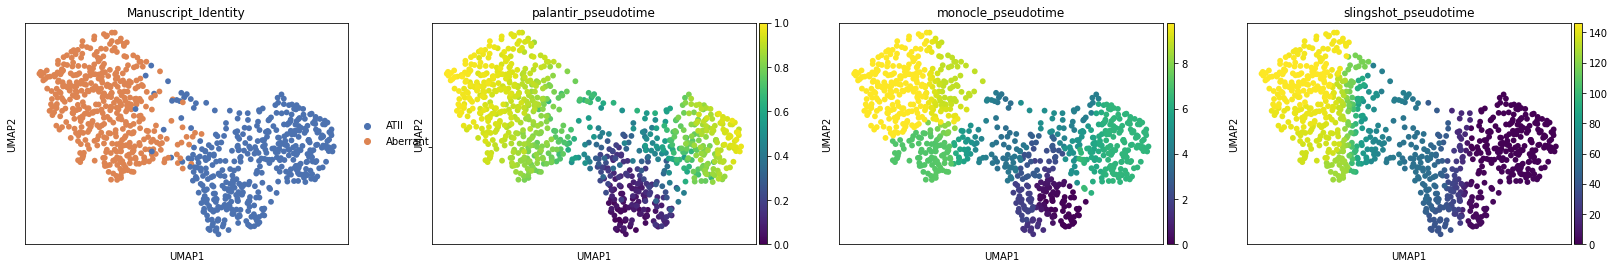

In [21]:
sc.pl.umap(adata_healthy_original, color=['Manuscript_Identity','palantir_pseudotime', 'monocle_pseudotime' ,'slingshot_pseudotime'])
sc.pl.umap(adata_disease_original, color=['Manuscript_Identity','palantir_pseudotime', 'monocle_pseudotime' ,'slingshot_pseudotime'])

<AxesSubplot: xlabel='slingshot_pseudotime', ylabel='Density'>

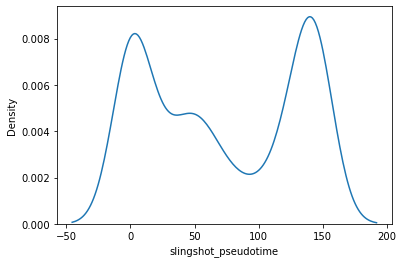

In [25]:
import seaborn as sb
sb.kdeplot(adata_disease_original.obs['slingshot_pseudotime'] )

<AxesSubplot: xlabel='monocle_pseudotime', ylabel='Density'>

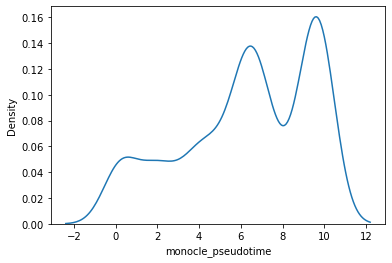

In [26]:
sb.kdeplot(adata_disease_original.obs['monocle_pseudotime'] )

<AxesSubplot: xlabel='monocle_pseudotime', ylabel='Density'>

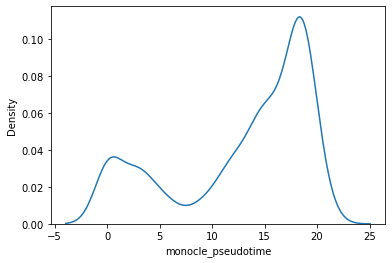

In [27]:
sb.kdeplot(adata_healthy_original.obs['monocle_pseudotime'] )

<AxesSubplot: xlabel='monocle_pseudotime', ylabel='Density'>

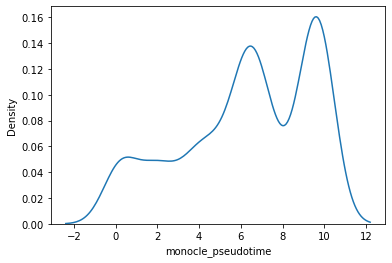

In [28]:
sb.kdeplot(adata_disease_original.obs['monocle_pseudotime'] )

In [29]:
anndata.__version__

'0.9.1'

In [ ]:
dir_path = '../GOOGLE_DRIVE_MOUNT/G2G_Analysis/G2G_paper_related/'

In [31]:
adata_disease_original.write_h5ad('adata_IPF_AT2_to_AberrantB_monocle_slingshot.h5ad')

In [32]:
adata_healthy_original.write_h5ad('adata_healthy_AT2_to_AT1_monocle_slingshot.h5ad')